In [1371]:
ASN_TO_NAME = dict()
for l in open("asn.txt","r").readlines():
    name, asn = l.strip().split(" ")
    ASN_TO_NAME[asn] = name

{'17676': 'SOFTBANK', '2516': 'KDDI', '2500': 'WIDE', '9605': 'DOCOMO', '4713': 'NTT', '9824': 'JCOM', '2527': 'SONET', '17511': 'OPTAGE', '2518': 'BIGGLOBE', '18126': 'CTC', '17506': 'UCOM', '2519': 'ARTERIA', '2497': 'IIJ'}


In [1372]:
data_loc = "/workdir"
THRES = 10

In [1373]:
from collections import defaultdict
from datetime import datetime
from enum import Enum
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

In [1269]:
def get_index(dt, year=-1):
    ts = datetime.timestamp(dt)
    if year == -1 : year = ts.y
    ref_ts = datetime.timestamp(datetime(year, 1, 1, 0)) 
    return int((ts-ref_ts)//3600)

def index_to_datetime(idx, year):
    return datetime.fromtimestamp( datetime.timestamp(datetime(year, 1, 1, 0)) + idx*3600 )

## DataManager
- expose loaded data: self.data[ASN]

In [1301]:
class DataManager:
    def __init__(self):
        self.data = defaultdict(list)  
        self.median = dict()
        
    def load(self, filename):
        f = open(f"{data_loc}/{filename}", "r")
        for line in f.readlines()[1:] :
            self.process_line(line)
            
    def process_line(self, line):
        c_asn, date_time, mean, cnt, _ = line.strip().split(",")
        if int(cnt) < THRES :
            return 

        date, hour = date_time.strip().split(" ")
        month, day, year = map(int, date.split("/"))
        hour = int(hour)
        
        dt = datetime(year, month, day, hour)
        self.data[c_asn].append( (dt, float(mean)) ) 
    
    def load_median(self, filename):
        f = open(f"{data_loc}/{filename}","r")
        for line in f.readlines()[1:] :
            asn, median, _, _ = line.strip().split(",")
            self.median[asn] = float(median)

## PlotDataASN
- build plot data, exposed to PlotData
- `x`, `y`, `asn`

In [1295]:
class PlotDataASN:
    def __init__(self, data, asn, label, st, end):
        self.data = data[asn] 
        self.st = st
        self.end = end
        self.asn = asn
        self.label = label
        self.median = -1
        self.x = []
        self.y = []
        
    def build_plot_data(self, year) :
        self.x, self.y = [], []
        for dt, v in sorted(self.data) :
            if self.st <= dt <= self.end :
                self.y.append(v)
                self.x.append(get_index(dt, year))   
    
    def set_median(self, v):
        self.median = v

In [1206]:
class PlotDataASN_MeanOf:
    def __init__(self, data, asn, label, st, end, p=7):
        self.p = p
        super().__init__(data, asn, st, end)
        
    def get_plot_data(self):
        x, y = [], []
        
        ref_year = self.st.year
        st_idx = get_index(self.st, ref_year)
        end_idx = get_index(self.end, ref_year)
        bucket = [0]*(end_idx-st_idx+1)
        
        for dt, v in self.data :
            if self.st <= dt <= self.end:
                bucket[idx-st_idx] = v
                
        total = c = 0
        for i in range(p):
            if bucket[i] == 0 : 
                continue
            total += bucket[i]
            c += 1

        for i in range(p, end-st+1):
            if bucket[i] != 0 : 
                total += bucket[i]
                c += 1
                
            v = 0 if c==0 else total/c
            y.append(v)
            x.append(i+st_idx)

            if bucket[i-p] != 0 : 
                total -= bucket[i-p]
                c -= 1
                
        return x, y

In [1296]:
class PlotDataList:
    def __init__(self, name):
        self.data = []
        self.name = name
        self.xticks = []
        self.xticklabels = []
        
    def set_data(self, d):
        self.data.append(d)
        
    def build_data(self, interval, fmt):
        year = 3000
        x_min, x_max = float('inf'), -float('inf')
        for d in self.data:
            year = min(d.st.year, year)
            
        for d in self.data:
            d.build_plot_data(year)
            x_min = min(d.x[0], x_min)
            x_max = max(d.x[-1], x_max)
        
        self.xticks = list(range(x_min, x_max+1, interval)) 
        self.xticklabels = list(map(lambda x: index_to_datetime(x, year).strftime(fmt), self.xticks))

## Visualizer
- for ploting the result graph
- need 1 argument `option: dict`
```json
option = {
    'period': [TS(), TS()],
    'tick': 24*7,
    'plot': '-',
    'fs': (18,3),
}
```

In [1327]:
class Visualizer:
    def __init__(self, option):
        self.op = option
        self.ylabel = "Median Throughput (MBps)" 
        self.fig = None
            
    def save_fig(self, name):
        self.fig.savefig(name, dpi=self.fig.dpi)
        
    def plot(self, all_plot_data):
        asn_number = len(all_plot_data)
        base = asn_number*100+10
        
        fig = plt.figure(figsize=self.op['fs'], dpi=110)
        
        for i in range(asn_number):
            
            plot_data_list = all_plot_data[i]
            plot_data_list.build_data(self.op['interval'], "%h %d")
            
            ax = fig.add_subplot(base+i+1)
            ax.set_title(plot_data_list.name)
            ax.set_ylabel(self.ylabel) 
            ax.set_xticks(plot_data_list.xticks)
            
            if i == asn_number-1:
                ax.set_xticklabels(plot_data_list.xticklabels)
            else :
                ax.set_xticklabels([""]*len(plot_data_list.xticks))
                
            self._plot(ax, all_plot_data[i])
            
            ax.grid()
            ax.legend()
        
        self.fig = fig
    
    def _plot(self, ax, all_plot_data):
        return

In [1328]:
class VisulizerPlot(Visualizer):    
    def _plot(self, ax, plot_data_list):
        for plot_data in plot_data_list.data :
            x = plot_data.x
            y = plot_data.y
            ax.plot(x, y, self.op['plot'], label=plot_data.label) 

In [1360]:
class VisulizerMedianPlot(Visualizer):
    def _plot(self, ax, plot_data_list):
        for plot_data in plot_data_list.data  :
                
            x = np.array(plot_data.x)
            y = np.array(plot_data.y)
            med = plot_data.median 
            
            ax.axhline(med, ls= '--',color='grey', lw=2, alpha=0.9)  
            ax.plot(x,y,self.op['plot'],label=plot_data.label,color='black', alpha=1) 

            trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
            ax.fill_between(x, y, med, where=y > med, facecolor='lightblue', interpolate=True)
            ax.fill_between(x, y, med, where=y < med, facecolor='red', alpha=0.4, interpolate=True)
            ax.set_ylim(0,80)
        self.fig = fig

In [1330]:
bq = DataManager()
bq.load("bq-full.csv")
bq.load_median('bq-median.csv')

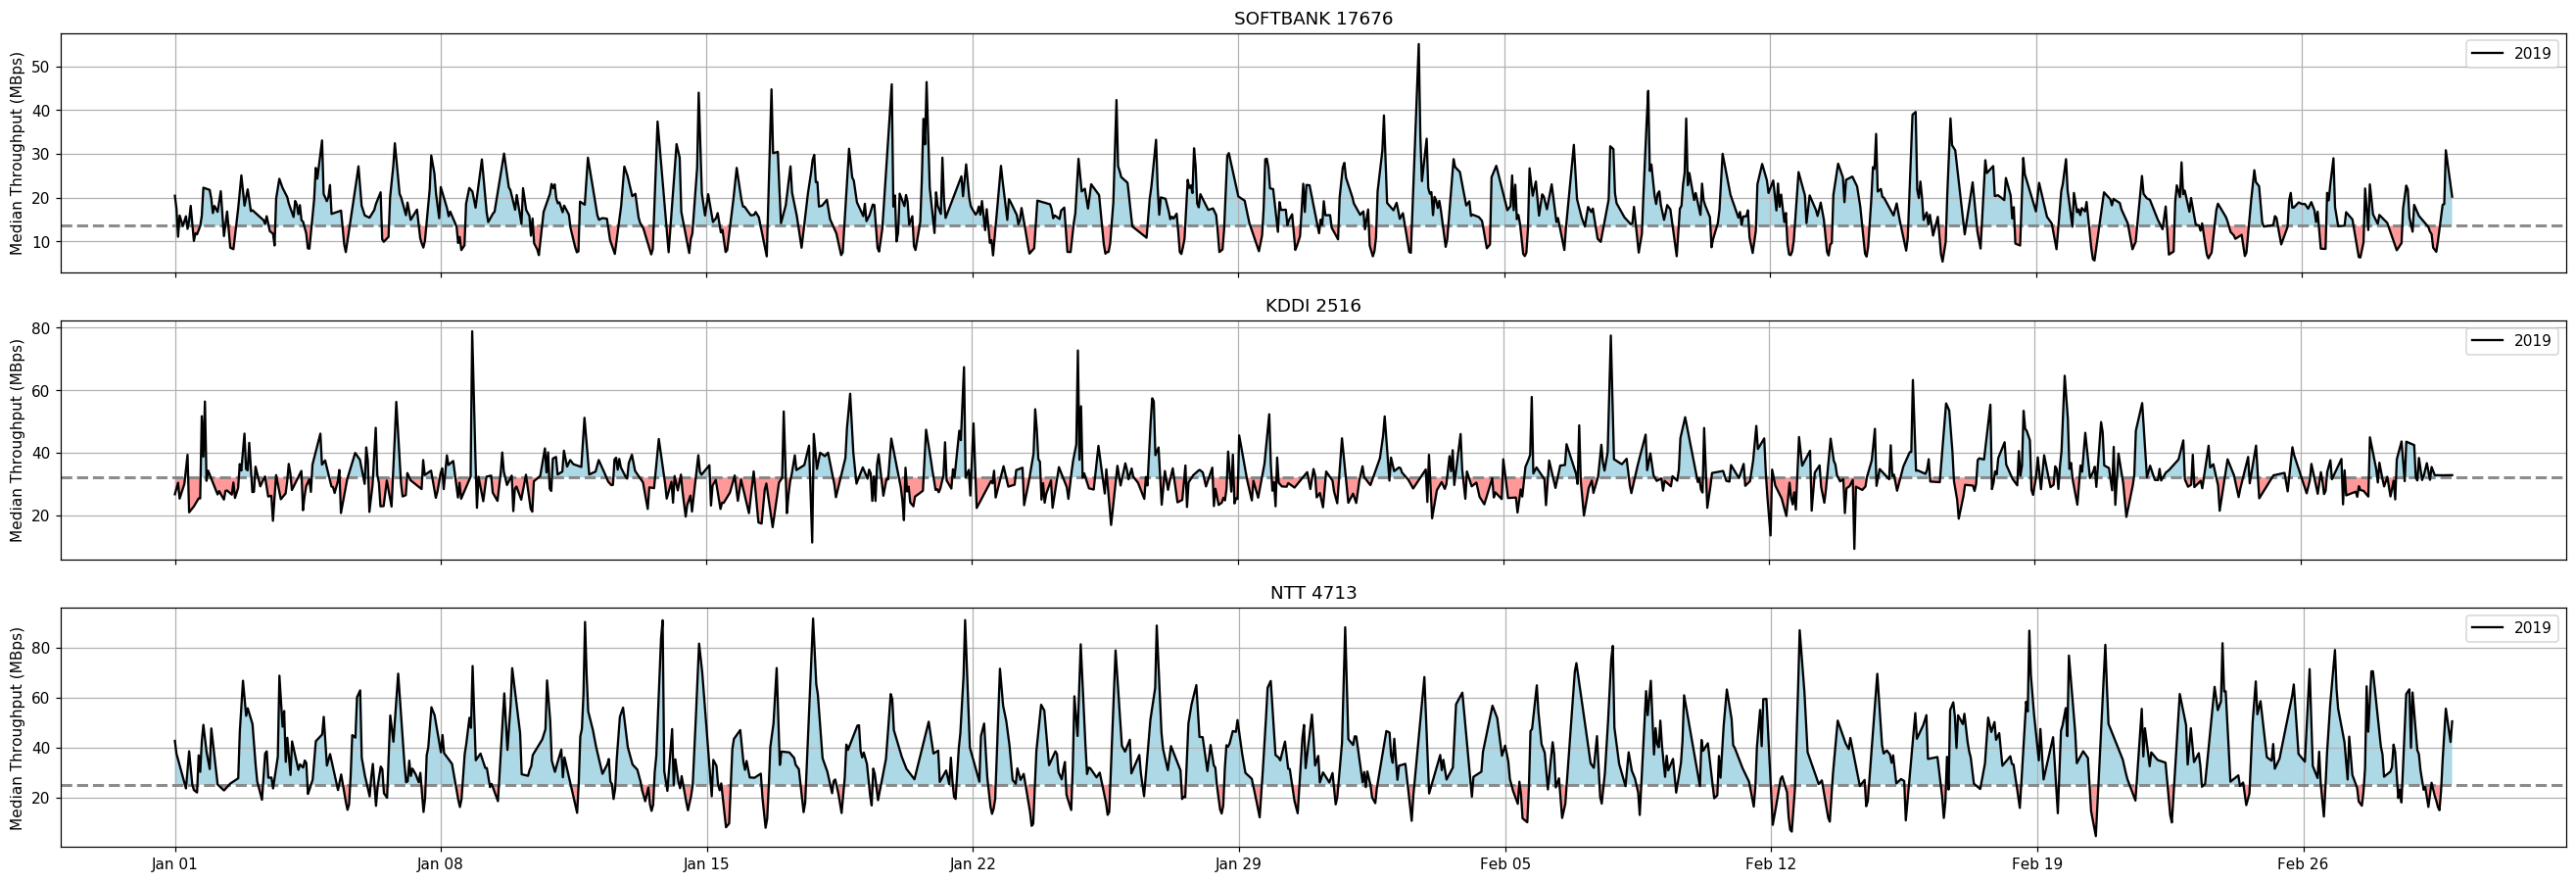

In [1333]:
plot_data = []
for asn in [SOFTBANK, KDDI, NTT]:
    data = PlotDataList(f"{ASN_TO_NAME[asn]} {asn}")
    asn_data = PlotDataASN( bq.data, asn, "", datetime(2020,1,1,0), datetime(2020,3,1,0))
    asn_data.set_median(bq.median[asn])
    data.set_data( asn_data )
    plot_data.append(data)
    
option = {
    'fs': (30,10),
    'plot': '-',
    'interval': 24*7
}
VisulizerMedianPlot(option).plot(plot_data)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


17.200353895183227 17676
33.06991247932063 2516
34.554680215020994 4713


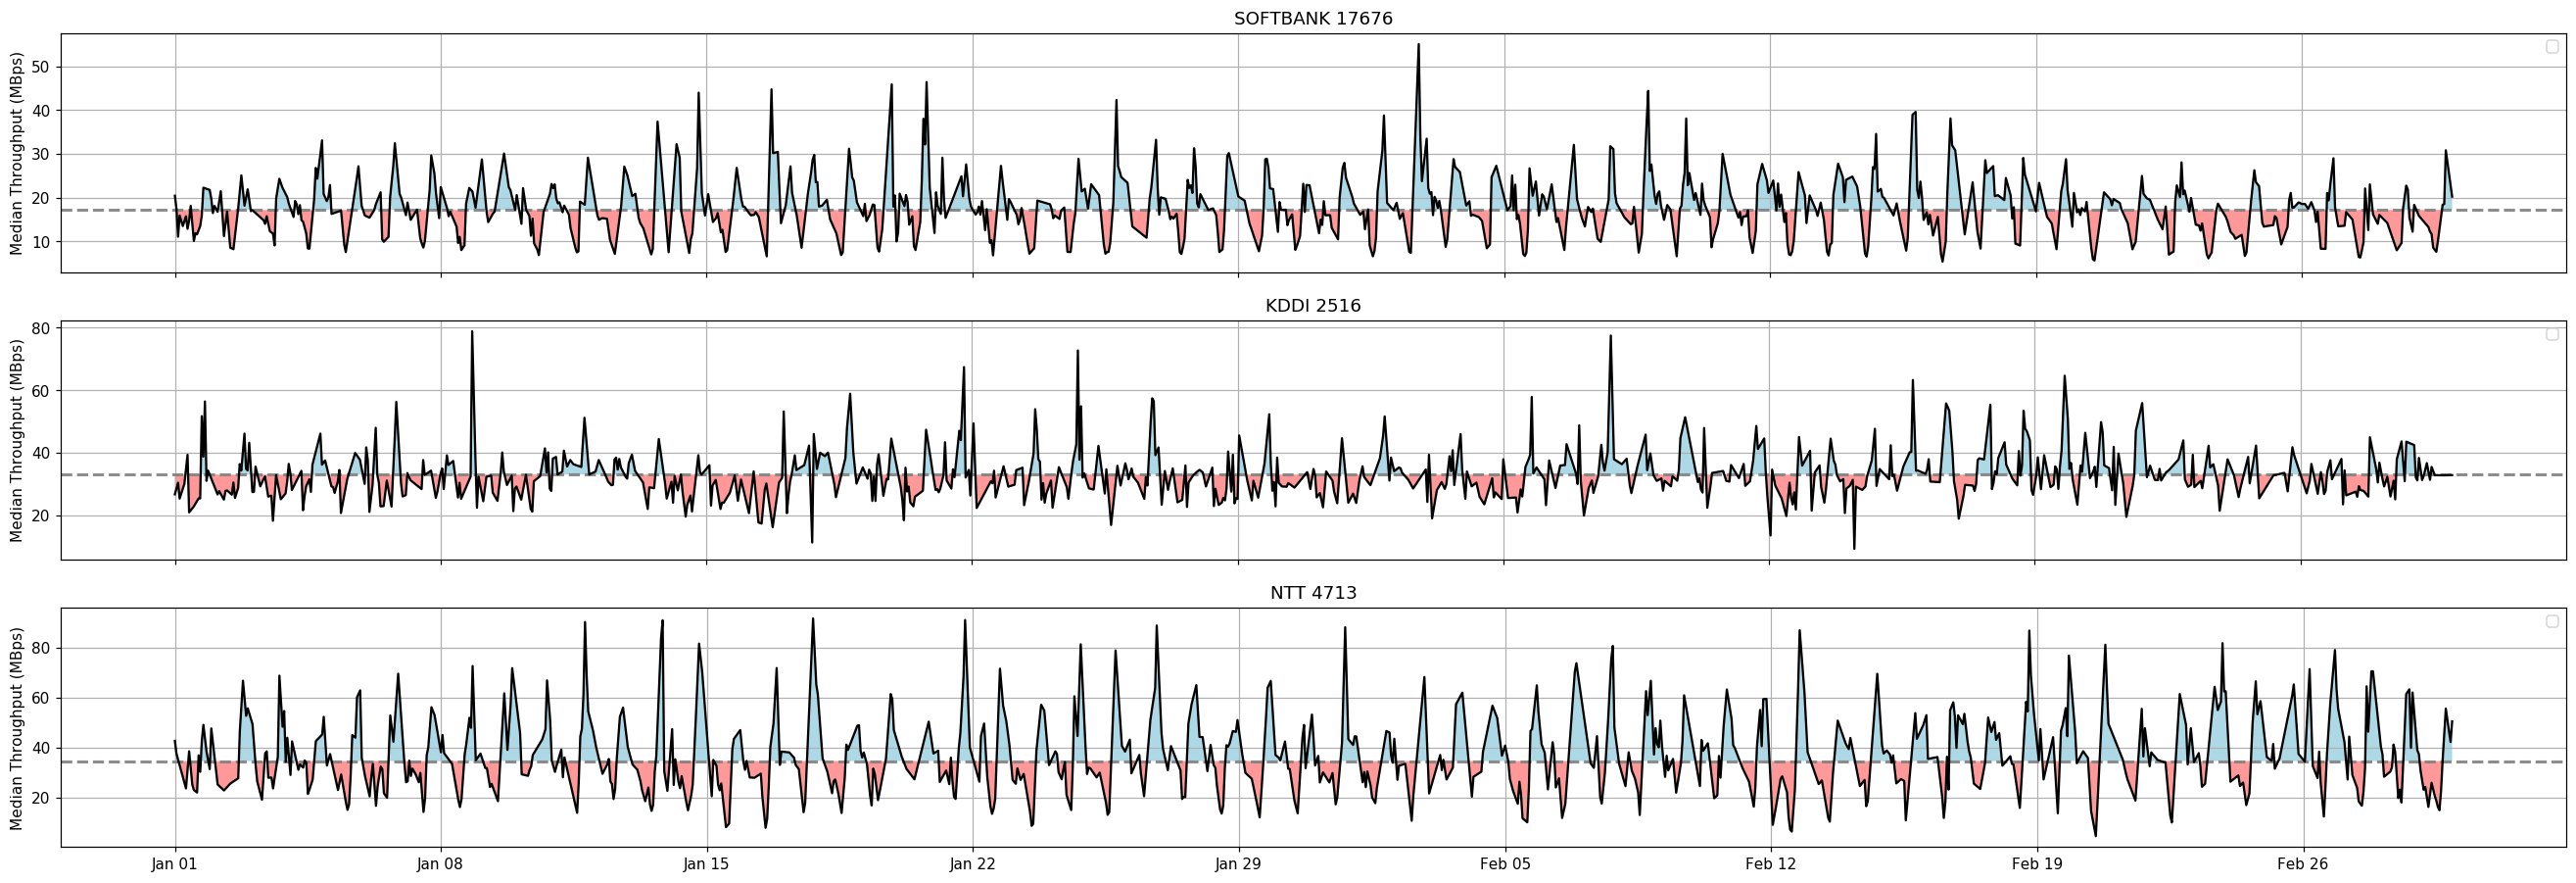

In [1348]:
_median = {}
plot_data = []
start = datetime(2020,1,1)
end = datetime(2020,7,1)

for asn in [SOFTBANK, KDDI, NTT]:
    y = []
    for dt, v in bq.data[asn]:
        if start <= dt <= end :
            y.append(v)
    _median[asn] = sorted(y)[len(y)//2]
    print(_median[asn], asn)
    
    data = PlotDataList(f"{ASN_TO_NAME[asn]} {asn}")
    asn_data = PlotDataASN( bq.data, asn, "", datetime(2020,1,1,0), datetime(2020,3,1,0))
    asn_data.set_median(_median[asn])
    data.set_data( asn_data )
    plot_data.append(data)
    
option = {
    'fs': (30,10),
    'plot': '-',
    'interval': 24*7
}
VisulizerMedianPlot(option).plot(plot_data)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


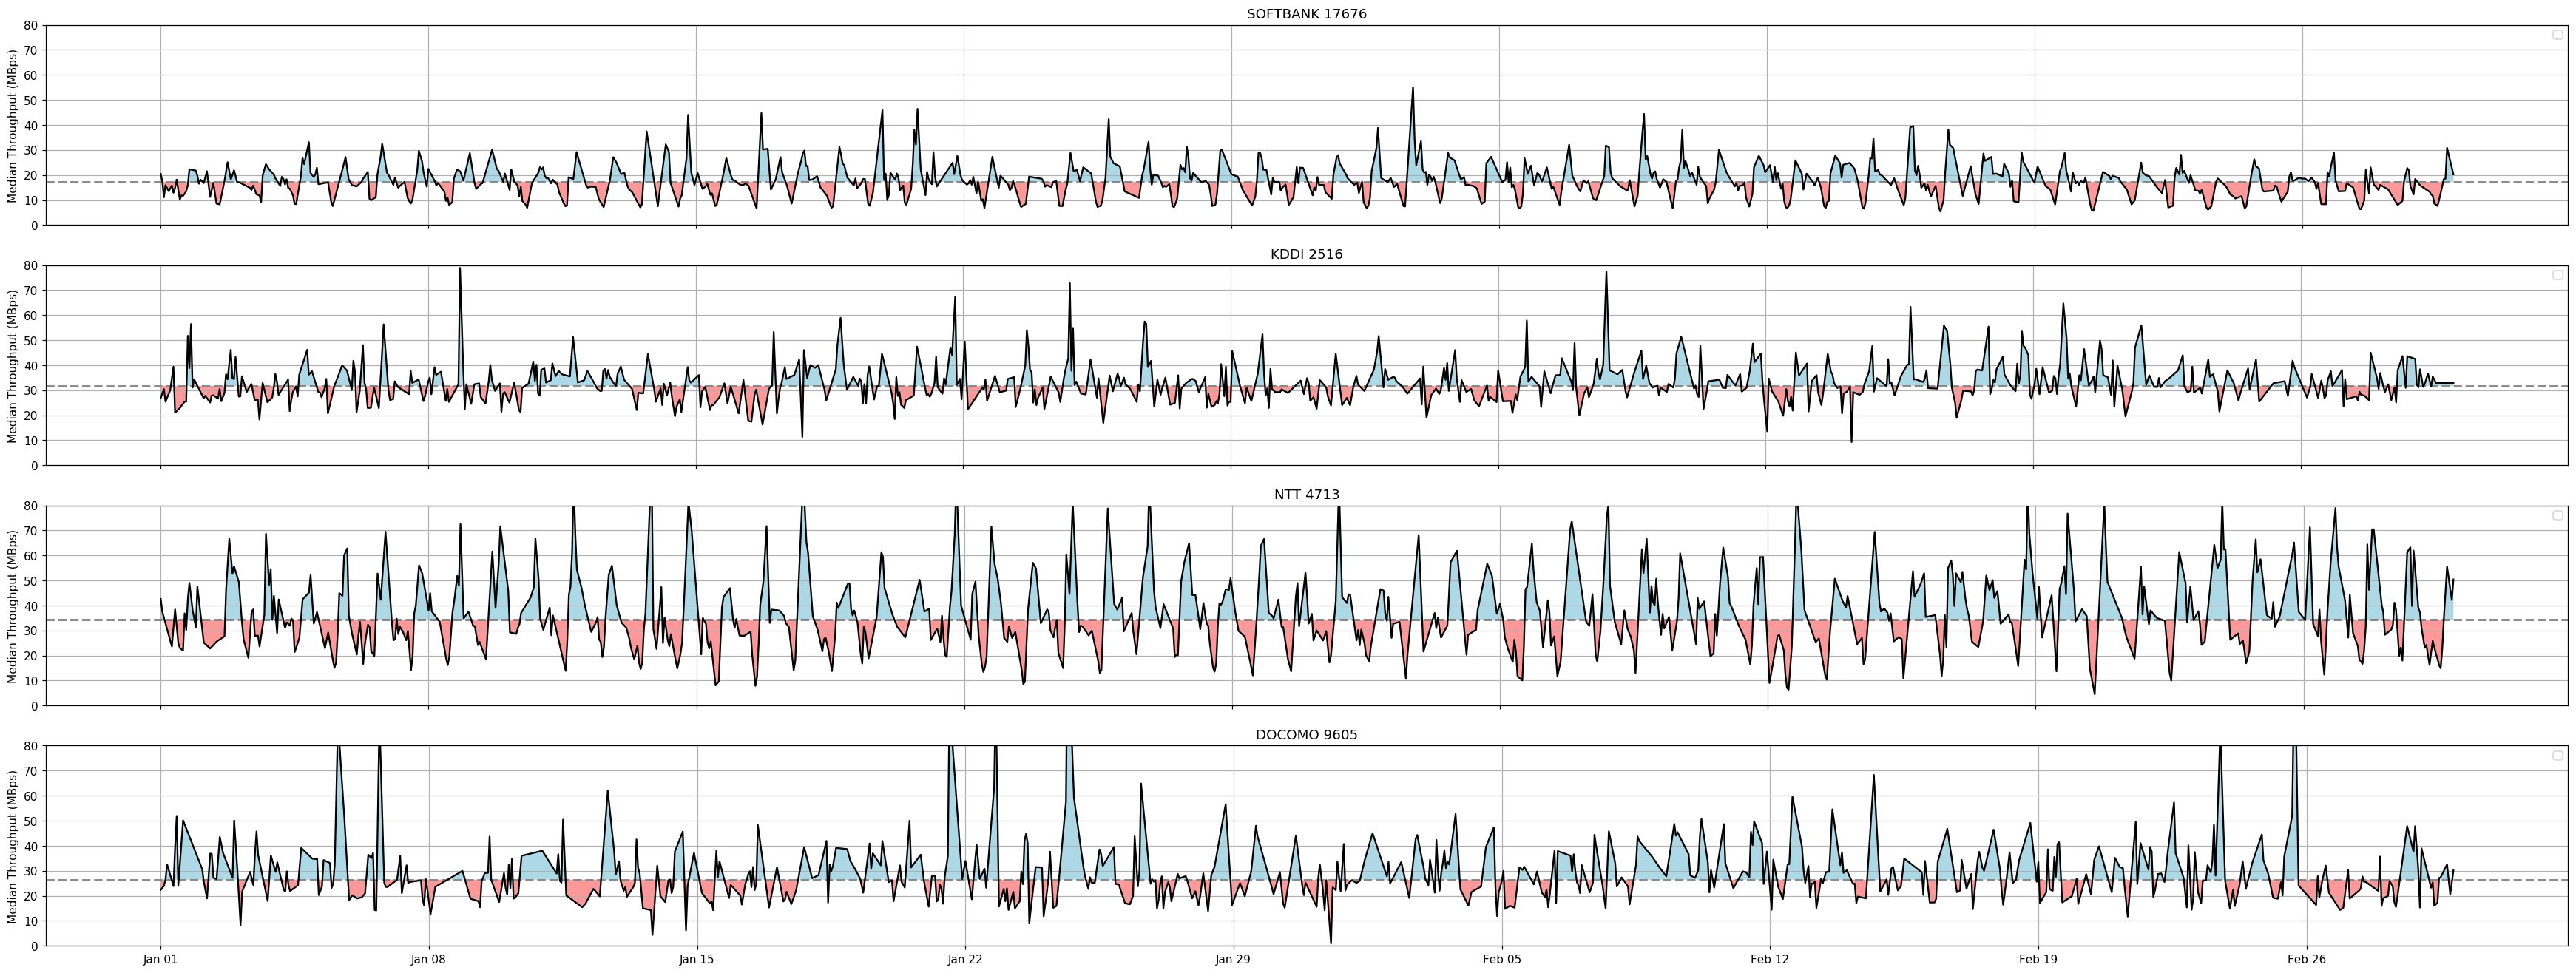

In [1368]:
_median = {}
plot_data = []
start = datetime(2020,1,1)
end = datetime(2020,3,1)

for asn in [SOFTBANK, KDDI, NTT, DOCOMO]:
    y = []
    for dt, v in bq.data[asn]:
        if start <= dt <= end :
            y.append(v)
    _median[asn] = sorted(y)[len(y)//2]
    
    data = PlotDataList(f"{ASN_TO_NAME[asn]} {asn}")
    asn_data = PlotDataASN( bq.data, asn, "", datetime(2020,1,1,0), datetime(2020,3,1,0))
    asn_data.set_median(_median[asn])
    data.set_data( asn_data )
    plot_data.append(data)
    
option = {
    'fs': (40,15),
    'plot': '-',
    'interval': 24*7
}
VisulizerMedianPlot(option).plot(plot_data)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


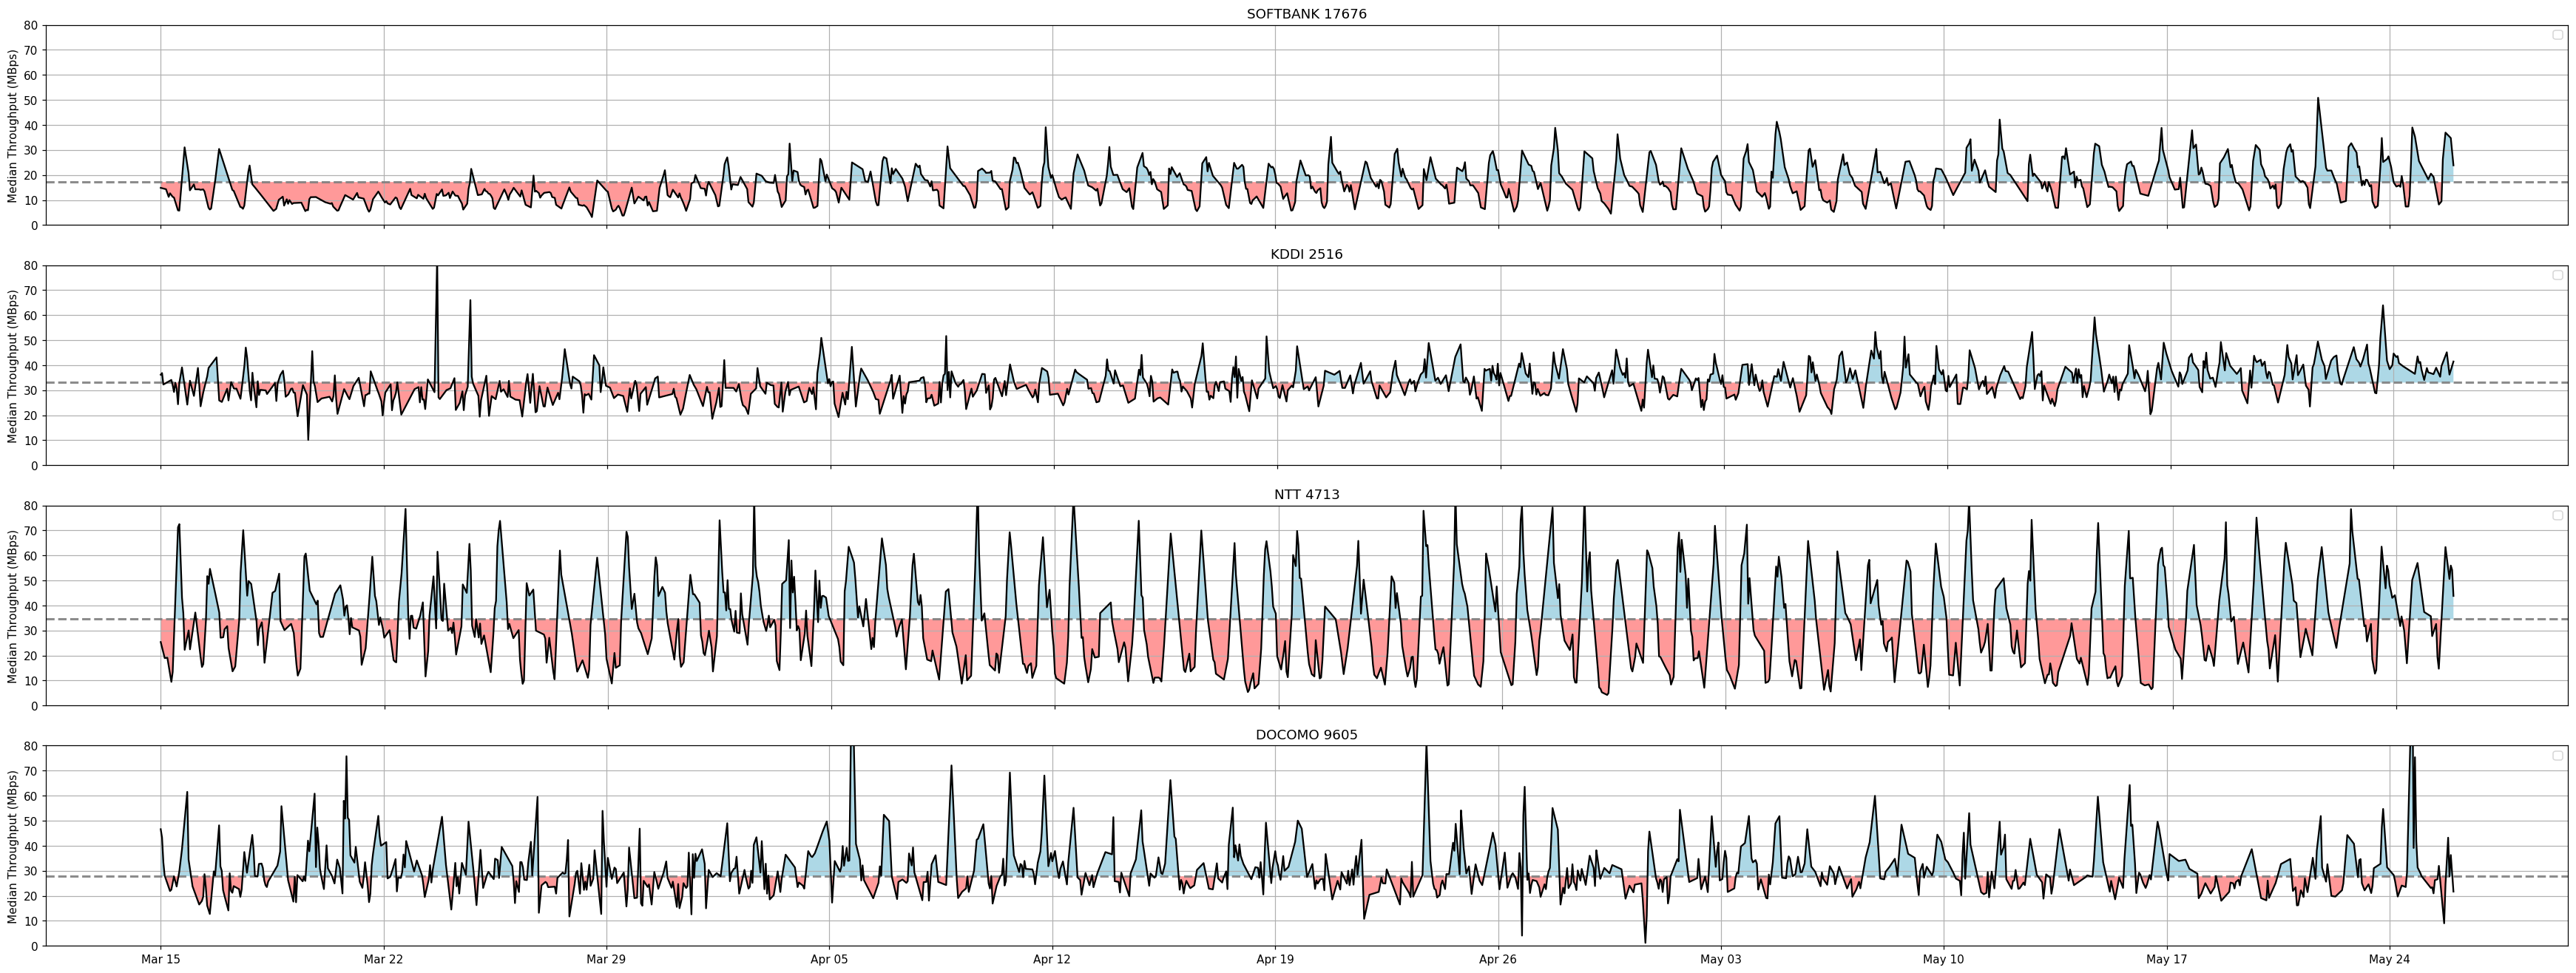

In [1365]:
_median = {}
plot_data = []
start = datetime(2020,1,1)
end = datetime(2020,7,1)

for asn in [SOFTBANK, KDDI, NTT, DOCOMO]:
    y = []
    for dt, v in bq.data[asn]:
        if start <= dt <= end :
            y.append(v)
    _median[asn] = sorted(y)[len(y)//2]
    
    data = PlotDataList(f"{ASN_TO_NAME[asn]} {asn}")
    asn_data = PlotDataASN( bq.data, asn, "", datetime(2020,3,15,0), datetime(2020,5,26,0))
    asn_data.set_median(_median[asn])
    data.set_data( asn_data )
    plot_data.append(data)
    
option = {
    'fs': (40,15),
    'plot': '-',
    'interval': 24*7
}
VisulizerMedianPlot(option).plot(plot_data)